# Differential power analysis

This type of Side Channel Attack was introduced by Paul Kocher et. al. in [DPA](https://paulkocher.com/doc/DifferentialPowerAnalysis.pdf) paper using DES algorithm as an example. Authors notice that there is significant difference of power consumption depending on the **values** that are being processed within DES algorithm. Important part of DPA is **selection function**. That is the function that is used for separating data into two different sets. For DES, selection function D(C,b,Ks) is defined as calculating value of bit b at the round 16 of the DES computation. 

The attacker observer some large number of crypto operations, makes a key guess Ks and evaluates the average of the function D on all of the traces. In other words, point-by-point average traces are calculated for:

1. traces that have a value of 1 for bit b
2. traces that have a value of 0 for bit b

Difference between these two traces is observed.

If the key guess Ks was incorrect, there is 50/50 chance that value of D matches the actual bit b of the target. This means that there is no correlation between D and the actual target values. Additionaly, if difference of these two avarage traces were to be plotted, it would appear flat. On the other hand, if the attacker correctly guessed Ks, value of the function D will **always** match the actual target bit b. This means that the plot would show spikes wherever there is strong correlation between D and the target values.

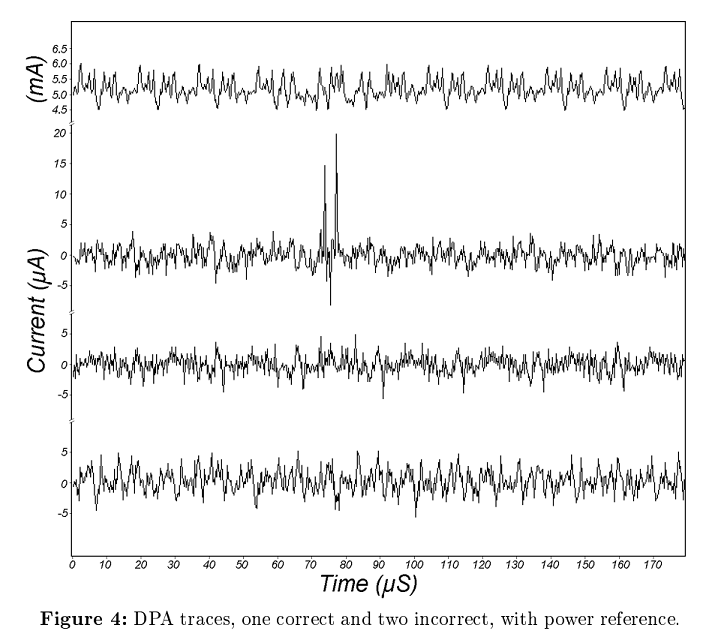

Even though DES was proven to be unsecure, and other more secure algorithms are in wide use, they are still succeptible to DPA if implemented without some kind of protection against this. In fact, the same principle will be used to attack the tinyAES implementation.

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tqdm.auto import trange

In [2]:
from utils.data_preparation import SCAML_Dataset

## Load data

In [3]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    colab_root_path = '/content/drive/MyDrive/'
    
    training_data_path = colab_root_path + 'datasets/tinyaes/train'
    testing_data_path = colab_root_path + 'datasets/tinyaes/test'
    
    save_models_root_path = colab_root_path + 'models/'
    
    log_root_path = colab_root_path + 'logs/'
else:
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'
    
    save_models_root_path = './models/'
    
    log_root_path = './logs/'

In [4]:
dataset = SCAML_Dataset()
shard_array = dataset.load_shards(testing_data_path)

256it [00:02, 121.60it/s]


In [5]:
# Chose random key(shard) to attack

example_shard_index = random.randint(0,256)

example_shard = shard_array[example_shard_index]
true_key = example_shard['keys'][:,0]
print(f"True key in shard {example_shard_index} : {true_key}")

True key in shard 196 : [196 130 143  81 161 136 212  57 254 211 181 101 179 123 192 184]


### Define AES utility

In [6]:
AES_SBOX = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def process_aes(input_byte, key_byte):
  sbox_input = input_byte ^ key_byte
  return AES_SBOX[sbox_input]

In [7]:
# Check if process_aes function is working properly
# sub_bytes_out is already calculated in the provided dataset.

"""
    key --> XOR <-- plain
             |
             | <--- sub_bytes_in
           -----
           | S |
           -----
             | <--- sub_bytes_out
"""

for pt_idx, plaintext in enumerate(example_shard['pts'].transpose()):
    for byte_idx, pt_byte in enumerate(plaintext):
        assert(process_aes(pt_byte, true_key[byte_idx]) == example_shard['sub_bytes_out'].transpose()[pt_idx][byte_idx])

## DPA algorithm setup

Pseudocode for the DPA attack algorithm is given in [this article](https://www.tandfonline.com/doi/pdf/10.1080/23742917.2016.1231523)

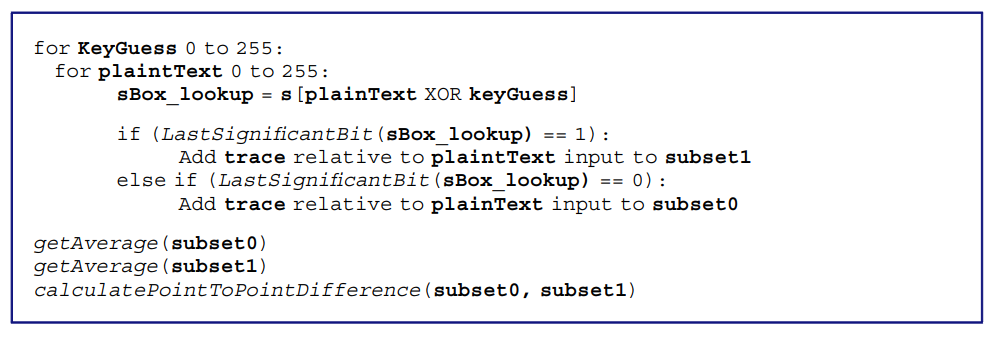

In [11]:
correct_key = example_shard['keys'][:,0]

In [12]:
correct_key

array([196, 130, 143,  81, 161, 136, 212,  57, 254, 211, 181, 101, 179,
       123, 192, 184], dtype=uint8)

In [16]:
# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]
correct_key = example_shard['keys']

for key_guess in tqdm(range(256), position=0):
  
    ones  = []
    zeros = []

    for trace_idx, trace in enumerate(example_shard['traces']):

        # Calculate the AES SBOX output based on the key guess and known plaintext
        leak = process_aes(key_guess, example_shard['pts'].transpose()[trace_idx][target_byte])

        # Monitor the leakage on one output bit
        # Analogous to Selection function from DPA paper
        if (leak & (0x01 << 1)):
            ones.append(trace[:, 0])
        else:
            zeros.append(trace[:, 0])

    ones_mean = np.asarray(ones).mean(axis=0)
    zeros_mean = np.asarray(zeros).mean(axis=0)
    mean_difference = abs(ones_mean - zeros_mean)

    plotting_data.append(mean_difference)

    # Look for the maximal difference => most possible leakage for this key guess
    key_guess_predictions[key_guess] = np.max(mean_difference)
  
    # print(f"Peak: {key_guess_predictions[key_guess]}")

    # If key is false -> half of the outputs will have 1 as first bit and half will have
    # 0 as first bit -> difference of means will be close to zero, and graph should appear flat
    # If key is correct -> there will be a spike either number of first bit == 0 is greater or number 
    # of first bit == 1 is greater and then the graph will spike in the areas where the target bit is processed

  0%|          | 0/256 [00:00<?, ?it/s]

## Evaluate DPA success

Plot the matrix of differential traces. We are expecting to see spikes (relative to the original data) in the places where there is a correlation between selection function D and the actual secret key.

In [33]:
fig = plt.figure(figsize=(45,45))

for key_guess, p in enumerate(tqdm(plotting_data)):
    ax = fig.add_subplot(16,16,key_guess+1)
#     ax.set_title(f"Differential trace for key guess {key_guess}")
    ax.plot(p)
plt.show()

  0%|          | 0/256 [00:00<?, ?it/s]

It is obvious that there are some plots that have spikes (mainly in the right area). Top 9 values will be plotted below:

In [41]:
top_9 = sorted(list(enumerate(key_guess_predictions)), key=lambda x: x[1])[:9]

In [47]:
top_9_indices = [x[0] for x in top_9]

In [48]:
top_9_indices

[178, 201, 188, 164, 169, 227, 234, 79, 11]

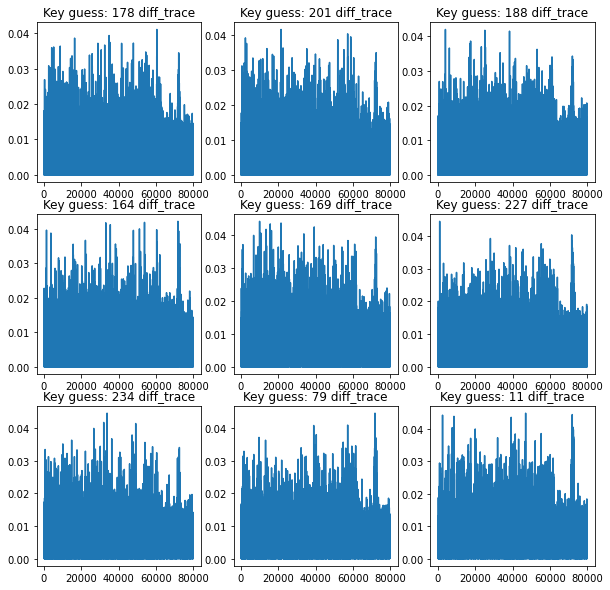

In [51]:
fig = plt.figure(figsize=(10,10))

for i, plt_idx in enumerate(top_9_indices):
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(f"Key guess: {plt_idx} diff_trace")
    ax.plot(plotting_data[plt_idx])

plt.show()

The actual key byte 0 is known:

In [53]:
known_key = example_shard['keys'][:,0]
print(known_key)

[196 130 143  81 161 136 212  57 254 211 181 101 179 123 192 184]


It is obvious that this attempt at DPA didn't recover the correct key byte, and because of that, some other bit will be tried below.

Define selection function for any of the target bits.

In [13]:
def DPA_selection_function(plaintext_byte, key_guess_byte, target_bit = 0):
    sbox_output = process_aes(plaintext_byte, key_guess_byte)

    if sbox_output & (0x01 << target_bit):
        return 1
    else:
        return 0

## Try other bits

Attack by accumulating difference values for different leakage bits.

In [54]:
from tqdm.auto import tqdm

# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]
key_guess_predictions_loop = []
# key_guesses = [0x00, 0x01, 0x21, 0xA2, known_key[0]]
for key_guess in tqdm(range(0, 256), desc=f"Key guess: {hex(key_guess)}, actual key: {hex(known_key[target_byte])}", position=0):
  
    ones  = []
    zeros = []

    for trace_idx, trace in enumerate(tqdm(example_shard['traces'], desc="Inspecting traces", position=1, leave=False)):

        # Accumulate predictions for all possible bits
        for tb in range(0,8):
            # Slice traces (leakage for the first key byte is probably at the beginning of the trace)
            plain_byte = example_shard['pts'].transpose()[trace_idx][target_byte]
            if(DPA_selection_function(key_guess, plain_byte, target_bit=tb) == 1):
                ones.append(trace[:10000, 0])
            else:
                zeros.append(trace[:10000, 0])

            print(f"Results for bit {tb}:")
            ones_mean_loop =np.asarray(ones).mean(axis=0)
            zeros_mean_loop = np.asarray(zeros).mean(axis=0)
            mean_difference_loop = abs(ones_mean_loop - zeros_mean_loop)

            key_guess_predictions_loop.append((key_guess, np.max(mean_difference_loop), tb))

    # print(f"Guess: {hex(key_guess)}")    
    ones_mean = np.asarray(ones).mean(axis=0)
    zeros_mean = np.asarray(zeros).mean(axis=0)
    mean_difference = abs(ones_mean - zeros_mean)

    plotting_data.append(mean_difference)

    # Look for the maximal difference => most possible leakage for this key guess
    key_guess_predictions[key_guess] = np.max(mean_difference)

Key guess: 0xff, actual key: 0xc4:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\avra\AppData\Local\Temp\ipykernel_26756\1237766754.py:23: RuntimeWarning: Mean of empty slice.
  ones_mean_loop = np.asarray(ones).mean(axis=0)
C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\avra\AppData\Local\Temp\ipykernel_26756\1237766754.py:24: RuntimeWarning: Mean of empty slice.
  zeros_mean_loop = np.asarray(zeros).mean(axis=0)


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

In [81]:
key_guess_inner = np.array(key_guess_predictions_loop)

In [89]:
correct_guesses=[]
for x in key_guess_predictions_loop:
    if x[0] == known_key[0]:
        correct_guesses.append(x)

In [100]:
max(correct_guesses, key=lambda x: x[1])

(196, 0.2355, 7)

Largest difference for correct key byte was detected when using bit 7 as a leakage point.

In [63]:
known_key

array([196, 130, 143,  81, 161, 136, 212,  57, 254, 211, 181, 101, 179,
       123, 192, 184], dtype=uint8)

## Evaluate DPA improvements

In [105]:
guess_prediction_indices = np.argsort(key_guess_predictions)[::-1]
# print(guess_prediction_indices)
predicted_key_values = np.asarray(key_guesses)[guess_prediction_indices]
print(f"Top 10 predicted first key byte values: {[hex(x) for x in predicted_key_values[:10]]}")
print(f"Most likely key byte max mean: {key_guess_predictions[predicted_key_values[0]]}")
print(f"Correct key: {hex(known_key[0])}")
print(f"Correct key byte max mean: {key_guess_predictions[known_key[0]]}")

# Plot mean differences on a single graph => spike is expected for the correct key
plt.figure(figsize=(15, 5))
for data in np.asarray(plotting_data)[guess_prediction_indices][:10]:
    plt.plot(data)

plt.title("Differential power traces")
labels = [f"key guess: {hex(x)}" for x in guess_prediction_indices]
plt.legend(labels, loc='best')
plt.show()

Top 10 predicted first key byte values: ['0xc4', '0xe8', '0x26', '0x1', '0x4e', '0xbc', '0x8b', '0xb9', '0xd9', '0x6f']
Most likely key byte max mean: 0.078857421875
Correct key: 0xc4
Correct key byte max mean: 0.078857421875


It is obvious from the graph that the correct key produced the biggest spike, which was expected.

DPA generally requires a lot of traces in order to work (average traces calculation), but it probably worked here because of the accumulation. Generally when using more bits, CPA can be used. It will be shown that some other techniques have better success.